In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
def process_company(company_data):
    try:
        m = company_data.money_raised_usd.values
        p = company_data.post_money_valuation_usd.values
        e = company_data.exit_value.values[0]

        if company_data.exit_type.values[0] == 3:
            ret = np.zeros_like(company_data.uuid) - 1
        elif company_data.shape[0] == 1:
            ret = [(m[0] / p[0] * e - m[0]) / m[0]]
        else:
            x0 = m / p # stake of investors at their first round
            x = (p[1:] - m[1:]) / p[1:] # dilution factors
            d = np.cumprod(x)[::-1]
            d = np.insert(d, len(d), 1)
            ret = (e * x0 * d - m) / m
        return pd.DataFrame(data=ret, index=company_data.uuid)
    except:
        return pd.DataFrame(data=[np.nan] * company_data.uuid.size, index=company_data.uuid)


def filter_dates(funding_round):
    return funding_round['announced_on'] < funding_round['exit_date']

In [9]:
rounds_data = pd.read_csv('obs_predicted_data.csv')

In [10]:
orgs = pd.read_csv("../../data/crunchbase/organizations.csv")
acqs = pd.read_csv("../../data/crunchbase/acquisitions.csv")
ipos = pd.read_csv("../../data/crunchbase/ipos.csv")

In [11]:
ipos = ipos[['org_uuid', 'went_public_on', 'valuation_price_usd']]
acqs = acqs[['acquiree_uuid', 'acquired_on', 'price_usd']]

In [12]:
rounds = rounds_data[['uuid', 'org_uuid', 'announced_on', 'money_raised_usd', 'post_money_valuation_usd']].copy()

ipos.columns = ['org_uuid', 'exit_date', 'exit_value']
acqs.columns = ['org_uuid', 'exit_date', 'exit_value']

clos = pd.DataFrame(orgs[['uuid', 'closed_on']].dropna())
clos.columns = ['org_uuid', 'exit_date']

ipos["exit_type"] = 1
acqs["exit_type"] = 2
clos["exit_type"] = 3
clos["exit_value"] = np.nan

exits = pd.concat([acqs, ipos, clos]).set_index("org_uuid")

In [13]:
rounds["exit_date"] = pd.to_datetime(rounds.org_uuid.map(exits["exit_date"].to_dict()))
rounds["exit_type"] = rounds.org_uuid.map(exits["exit_type"].to_dict()).fillna(value=4).astype(int)
rounds["exit_value"] = rounds.org_uuid.map(exits["exit_value"].to_dict())

In [14]:
ref_date = '1926-01-01'
rounds.announced_on = pd.Timestamp(ref_date) + rounds.announced_on * pd.Timedelta('1s')

In [15]:
private = rounds[rounds.exit_type == 4]
rounds = rounds[(rounds.announced_on < rounds.exit_date)]
rounds = rounds.sort_values(by=['org_uuid', 'announced_on'])

In [16]:
rounds['return_usd'] = rounds.uuid.map(rounds.groupby('org_uuid').apply(process_company).droplevel(0)[0]) + 1

In [17]:
rounds = rounds.drop(columns=['uuid'])
rounds.insert(1, 'group_num', np.nan)
rounds.insert(2, 'seg_num', np.nan)

rounds.columns = ['company_num', 'group_num', 'seg_num', 'round_date', 'raised_usd',
                  'postvalue_usd', 'exit_date', 'exit_type', 'exit_value', 'return_usd']
rounds = rounds[rounds.round_date > '1990-01-01']

In [18]:
private = private.drop(columns=['uuid'])
private.insert(1, 'group_num', np.nan)
private.insert(2, 'seg_num', np.nan)
private.insert(9, 'return_usd', np.nan)

private.columns = ['company_num', 'group_num', 'seg_num', 'round_date', 'raised_usd',
                  'postvalue_usd', 'exit_date', 'exit_type', 'exit_value', 'return_usd']
private = private[private.round_date > '1990-01-01']
private.exit_date = np.nan

In [19]:
complete = pd.concat([rounds, private])
complete.exit_date = pd.to_datetime(complete.exit_date)
complete[complete.return_usd == 0] = np.nan
complete = complete[complete.return_usd < 3000]
complete.to_csv('../../data/data.csv', index=False)

In [20]:
complete

,company_num,group_num,seg_num,round_date,raised_usd,postvalue_usd,exit_date,exit_type,exit_value,return_usd
8886,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,NaN,NaN,2016-01-11,45000000.0,2.104294e+08,2020-12-15,1.0,5.775800e+08,2.442438
8887,002e0b73-ab4e-bfd5-0d9a-e6df8fede446,NaN,NaN,2020-07-15,72500000.0,6.582064e+08,2020-12-15,1.0,5.775800e+08,0.877506
8895,00337756-938c-bd48-80c3-1505a90a809e,NaN,NaN,2017-01-20,3956782.0,2.737539e+07,2021-12-31,2.0,1.353151e+08,4.942946
8904,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,NaN,NaN,2020-11-09,130000000.0,7.351335e+08,2021-03-11,1.0,7.078260e+08,0.962854
8968,0059ddde-8c8e-2058-f0e4-cf9225ab8ae6,NaN,NaN,2008-07-15,24979595.0,1.076227e+08,2015-03-05,2.0,2.206305e+08,1.377495
...,...,...,...,...,...,...,...,...,...,...
120112,ffe74ad7-43eb-bd06-32ad-19de354a67bd,NaN,NaN,2014-04-17,40000000.0,3.123259e+08,2020-01-30,1.0,1.710000e+09,3.684063
8820,ffe74ad7-43eb-bd06-32ad-19de354a67bd,NaN,NaN,2015-12-08,65000000.0,8.600000e+08,2020-01-30,1.0,1.710000e+09,1.53446
8821,ffe74ad7-43eb-bd06-32ad-19de354a67bd,NaN,NaN,2018-08-22,220000000.0,1.500000e+09,2020-01-30,1.0,1.710000e+09,0.986325
120113,ffe74ad7-43eb-bd06-32ad-19de354a67bd,NaN,NaN,2018-08-22,130000000.0,2.497595e+09,2020-01-30,1.0,1.710000e+09,0.684659


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
complete = pd.read_csv('../../data/data.csv')

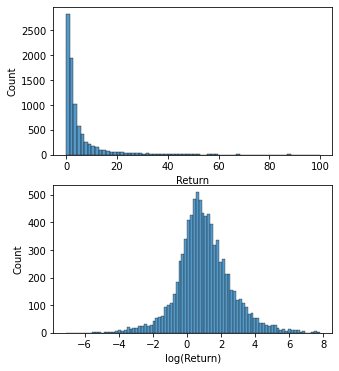

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
sns.histplot(complete[complete.return_usd < 100].return_usd, ax=axs[0], bins=70)
sns.histplot(np.log(complete.return_usd.dropna()), ax=axs[1])
axs[0].set_xlabel('Return')
axs[1].set_xlabel('log(Return)')
plt.savefig('figures/returns.pdf')